$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [101]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [102]:
import cs236781.plot as plot
import cs236781.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/nadavhalahmi/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/nadavhalahmi/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/nadavhalahmi/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [103]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


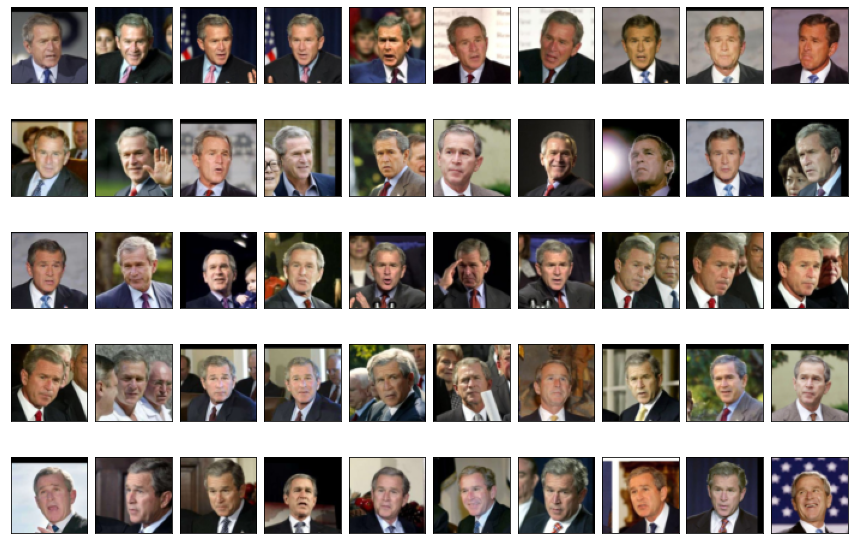

In [104]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [105]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [106]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(3, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): AvgPool2d(kern

**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [107]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (cnn): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(4, 4))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(4, 4))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(4, 4))
    (7): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [108]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [109]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223, dtype=torch.float64)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

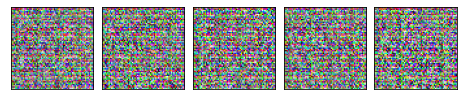

In [110]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw3/answers.py` module.

In [111]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 64, 'z_dim': 128, 'data_label': 1, 'label_noise': 0.25, 'discriminator_optimizer': {'type': 'Adam', 'weight_decay': 0.015, 'betas': (0.9, 0.999), 'lr': 0.0002}, 'generator_optimizer': {'type': 'Adam', 'weight_decay': 0.015, 'betas': (0.9, 0.999), 'lr': 0.0002}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw3.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.83it/s]
Discriminator loss: 1.372023171848721
Generator loss:     0.6166194637278942
Saved checkpoint.


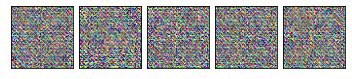

--- EPOCH 2/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.27it/s]
Discriminator loss: 1.3086081875695124
Generator loss:     0.6413256628212625


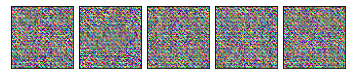

--- EPOCH 3/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.24it/s]
Discriminator loss: 1.2821185323927138
Generator loss:     0.6568015716181338


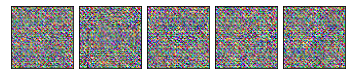

--- EPOCH 4/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.20it/s]
Discriminator loss: 1.2635009818606906
Generator loss:     0.6626502843472171


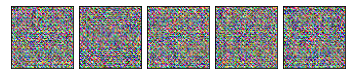

--- EPOCH 5/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.78it/s]
Discriminator loss: 1.2582377592722576
Generator loss:     0.6651546808406383


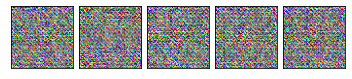

--- EPOCH 6/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.24it/s]
Discriminator loss: 1.2531163824929132
Generator loss:     0.6673067599053023


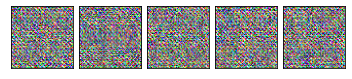

--- EPOCH 7/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.24it/s]
Discriminator loss: 1.2469931311077542
Generator loss:     0.6718397795162017


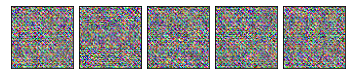

--- EPOCH 8/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.45it/s]
Discriminator loss: 1.2401317093107436
Generator loss:     0.6720301883433462


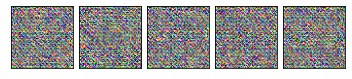

--- EPOCH 9/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.38it/s]
Discriminator loss: 1.2439082596037123
Generator loss:     0.6732029619606217


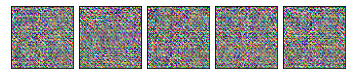

--- EPOCH 10/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.61it/s]
Discriminator loss: 1.2344376511043973
Generator loss:     0.6753497527082744


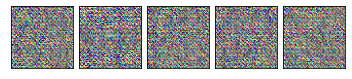

--- EPOCH 11/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.44it/s]
Discriminator loss: 1.23524808883667
Generator loss:     0.6764690396768238


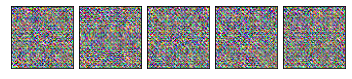

--- EPOCH 12/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.63it/s]
Discriminator loss: 1.2334660689036052
Generator loss:     0.6775091706241906


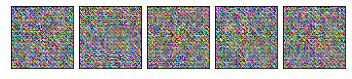

--- EPOCH 13/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.59it/s]
Discriminator loss: 1.2327931192186143
Generator loss:     0.6779301556572718


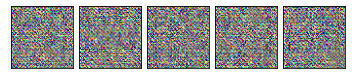

--- EPOCH 14/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.41it/s]
Discriminator loss: 1.225540320078532
Generator loss:     0.6806402187532056


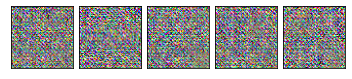

--- EPOCH 15/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.36it/s]
Discriminator loss: 1.2272882594002619
Generator loss:     0.6812784668607436


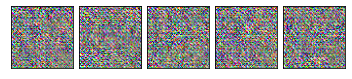

--- EPOCH 16/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.71it/s]
Discriminator loss: 1.2256579134199355
Generator loss:     0.6815277138382009


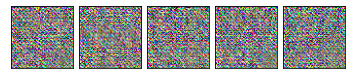

--- EPOCH 17/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.43it/s]
Discriminator loss: 1.2249645392100017
Generator loss:     0.6815365879553177


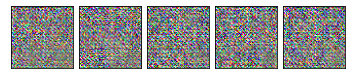

--- EPOCH 18/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.78it/s]
Discriminator loss: 1.2253939045800104
Generator loss:     0.6811251067280291


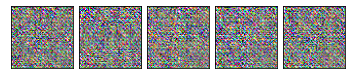

--- EPOCH 19/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.28it/s]
Discriminator loss: 1.2277062733968098
Generator loss:     0.6820214428288269


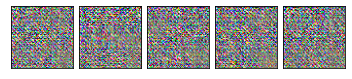

--- EPOCH 20/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.28it/s]
Discriminator loss: 1.2237268553839789
Generator loss:     0.6823020210298201


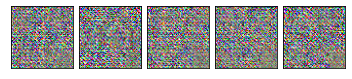

--- EPOCH 21/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.43it/s]
Discriminator loss: 1.221586611535814
Generator loss:     0.6836195263146129


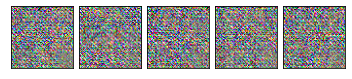

--- EPOCH 22/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.36it/s]
Discriminator loss: 1.2188783751593695
Generator loss:     0.6832282565350444


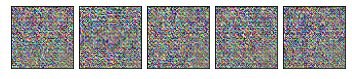

--- EPOCH 23/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.30it/s]
Discriminator loss: 1.217767556508382
Generator loss:     0.6834441133950002


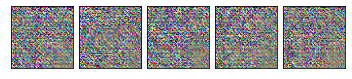

--- EPOCH 24/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.00it/s]
Discriminator loss: 1.2151937749650743
Generator loss:     0.6847444507848297


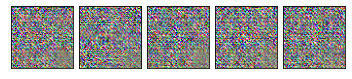

--- EPOCH 25/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.38it/s]
Discriminator loss: 1.2172220945358276
Generator loss:     0.6864043022218334


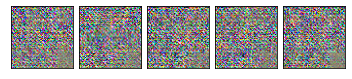

--- EPOCH 26/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.21it/s]
Discriminator loss: 1.215402881304423
Generator loss:     0.6858106549642158


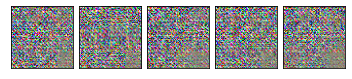

--- EPOCH 27/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.53it/s]
Discriminator loss: 1.214402397473653
Generator loss:     0.6861643170316394


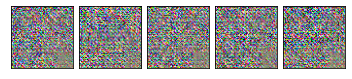

--- EPOCH 28/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.30it/s]
Discriminator loss: 1.2119053734673395
Generator loss:     0.6868742736019455


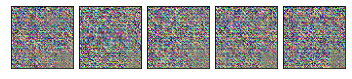

--- EPOCH 29/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.47it/s]
Discriminator loss: 1.211269948217604
Generator loss:     0.6862957619891781


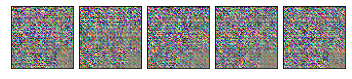

--- EPOCH 30/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.41it/s]
Discriminator loss: 1.2115377717547946
Generator loss:     0.6863014308421879


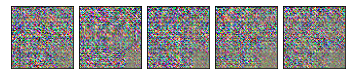

--- EPOCH 31/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.23it/s]
Discriminator loss: 1.2129264275232952
Generator loss:     0.6875206302726729


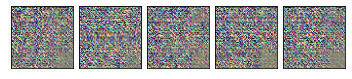

--- EPOCH 32/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.40it/s]
Discriminator loss: 1.208712723520067
Generator loss:     0.6869850483041985


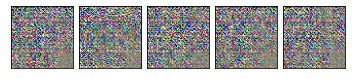

--- EPOCH 33/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.47it/s]
Discriminator loss: 1.2104974190394084
Generator loss:     0.6875376841104875


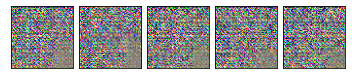

--- EPOCH 34/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.70it/s]
Discriminator loss: 1.2085399097866483
Generator loss:     0.6884827971983332


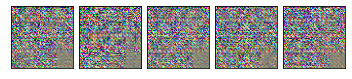

--- EPOCH 35/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.37it/s]
Discriminator loss: 1.2086056603325739
Generator loss:     0.6879345219094497


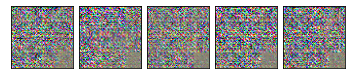

--- EPOCH 36/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.55it/s]
Discriminator loss: 1.205883714887831
Generator loss:     0.6884929773773512


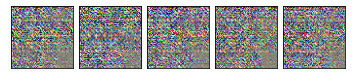

--- EPOCH 37/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.55it/s]
Discriminator loss: 1.2049225038952298
Generator loss:     0.6889502216583452


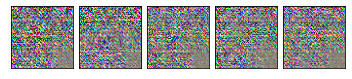

--- EPOCH 38/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.45it/s]
Discriminator loss: 1.2065043052037556
Generator loss:     0.6887337016621758


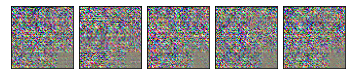

--- EPOCH 39/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.73it/s]
Discriminator loss: 1.2073405318790011
Generator loss:     0.6883923743096827


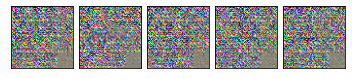

--- EPOCH 40/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.51it/s]
Discriminator loss: 1.202658971150716
Generator loss:     0.6893358086952657


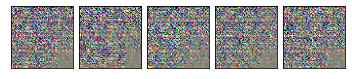

--- EPOCH 41/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.11it/s]
Discriminator loss: 1.2032517592112224
Generator loss:     0.6893167660372698


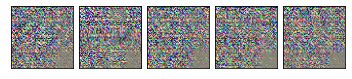

--- EPOCH 42/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.26it/s]
Discriminator loss: 1.2088264756732516
Generator loss:     0.6887834490383592


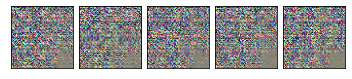

--- EPOCH 43/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.59it/s]
Discriminator loss: 1.2060165537728205
Generator loss:     0.6892814861828183


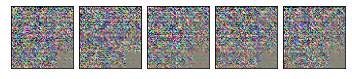

--- EPOCH 44/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.36it/s]
Discriminator loss: 1.20298351181878
Generator loss:     0.6890888738836286


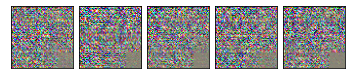

--- EPOCH 45/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.44it/s]
Discriminator loss: 1.2043144173092313
Generator loss:     0.6890424318438818


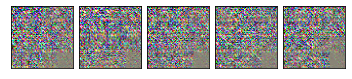

--- EPOCH 46/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.38it/s]
Discriminator loss: 1.2018054856194391
Generator loss:     0.6892224868019888


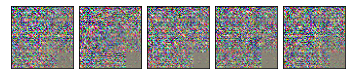

--- EPOCH 47/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.24it/s]
Discriminator loss: 1.2047548294067383
Generator loss:     0.6897358116539647


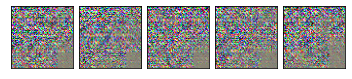

--- EPOCH 48/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.70it/s]
Discriminator loss: 1.2003965377807617
Generator loss:     0.6896276729530323


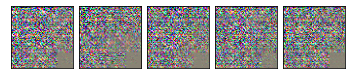

--- EPOCH 49/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.08it/s]
Discriminator loss: 1.1996819840537176
Generator loss:     0.6896714679165158


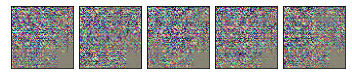

--- EPOCH 50/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.34it/s]
Discriminator loss: 1.1980220741695828
Generator loss:     0.6897774294291291


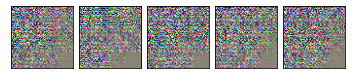

--- EPOCH 51/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.32it/s]
Discriminator loss: 1.19998037815094
Generator loss:     0.6900565896664956


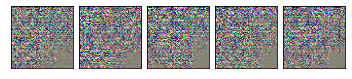

--- EPOCH 52/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.36it/s]
Discriminator loss: 1.201708237330119
Generator loss:     0.6895952104356414


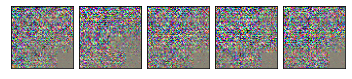

--- EPOCH 53/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.41it/s]
Discriminator loss: 1.2043255964914958
Generator loss:     0.6902674428992202


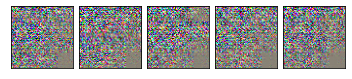

--- EPOCH 54/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.46it/s]
Discriminator loss: 1.1976350413428412
Generator loss:     0.6901208480617226


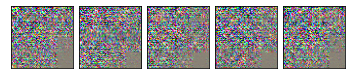

--- EPOCH 55/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.48it/s]
Discriminator loss: 1.1956123908360798
Generator loss:     0.6906113771166247


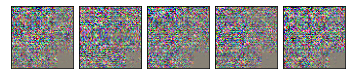

--- EPOCH 56/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.24it/s]
Discriminator loss: 1.1927846405241225
Generator loss:     0.6900676983334075


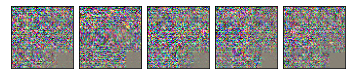

--- EPOCH 57/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.46it/s]
Discriminator loss: 1.1920974387062921
Generator loss:     0.6901108918316116


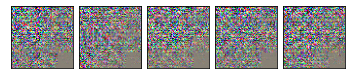

--- EPOCH 58/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.37it/s]
Discriminator loss: 1.1963984966278076
Generator loss:     0.6905293194168378


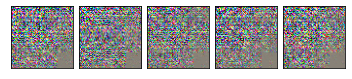

--- EPOCH 59/100 ---
100%|██████████| 9/9 [00:03<00:00,  2.27it/s]
Discriminator loss: 1.1929736137390137
Generator loss:     0.6900280528358491


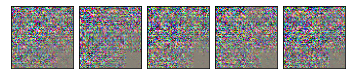

--- EPOCH 60/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.08it/s]
Discriminator loss: 1.1911764409806993
Generator loss:     0.6900147034842373


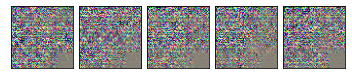

--- EPOCH 61/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.14it/s]
Discriminator loss: 1.1972277032004461
Generator loss:     0.6900924297778412


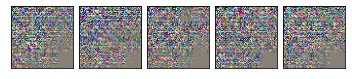

--- EPOCH 62/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.28it/s]
Discriminator loss: 1.1932469209035237
Generator loss:     0.6904143270339312


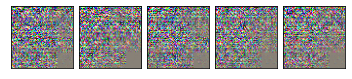

--- EPOCH 63/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.00it/s]
Discriminator loss: 1.1977166599697537
Generator loss:     0.6903407453738447


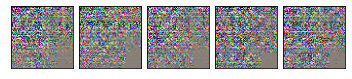

--- EPOCH 64/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.93it/s]
Discriminator loss: 1.195376952489217
Generator loss:     0.6905795574939959


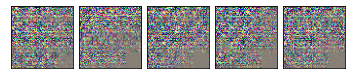

--- EPOCH 65/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.51it/s]
Discriminator loss: 1.192294716835022
Generator loss:     0.6897308058797854


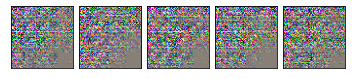

--- EPOCH 66/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.25it/s]
Discriminator loss: 1.1897930171754625
Generator loss:     0.6902710284634997


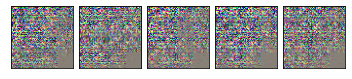

--- EPOCH 67/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.50it/s]
Discriminator loss: 1.1889933612611558
Generator loss:     0.6901521498308493


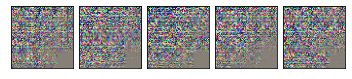

--- EPOCH 68/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.50it/s]
Discriminator loss: 1.195028715663486
Generator loss:     0.6900354729813549


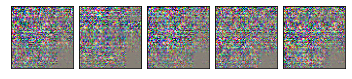

--- EPOCH 69/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.01it/s]
Discriminator loss: 1.1899931033452351
Generator loss:     0.6904024018910097


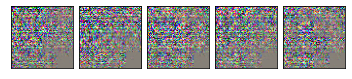

--- EPOCH 70/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.77it/s]
Discriminator loss: 1.1953937345080905
Generator loss:     0.6902494234822908


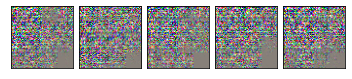

--- EPOCH 71/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.20it/s]
Discriminator loss: 1.1980525255203247
Generator loss:     0.6899255446300959


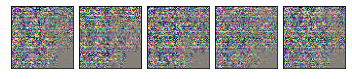

--- EPOCH 72/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.38it/s]
Discriminator loss: 1.1911972761154175
Generator loss:     0.691059030828465


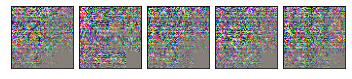

--- EPOCH 73/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.40it/s]
Discriminator loss: 1.1865884065628052
Generator loss:     0.6905201039512748


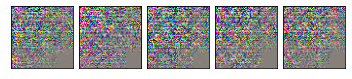

--- EPOCH 74/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.60it/s]
Discriminator loss: 1.1891483200920954
Generator loss:     0.6903515261685196


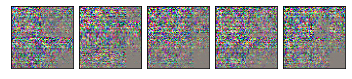

--- EPOCH 75/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.08it/s]
Discriminator loss: 1.1908338997099135
Generator loss:     0.6909501971329904


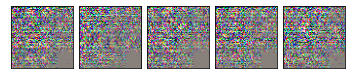

--- EPOCH 76/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.07it/s]
Discriminator loss: 1.1905988852183025
Generator loss:     0.6902410715144635


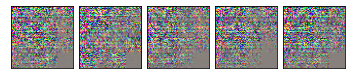

--- EPOCH 77/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.14it/s]
Discriminator loss: 1.1942200395796034
Generator loss:     0.6902005050732399


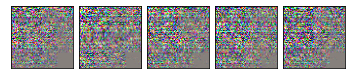

--- EPOCH 78/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.27it/s]
Discriminator loss: 1.1896327866448297
Generator loss:     0.6911324262223439


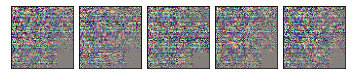

--- EPOCH 79/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.20it/s]
Discriminator loss: 1.1868721379174128
Generator loss:     0.6908940463241533


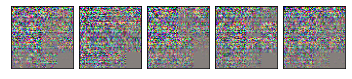

--- EPOCH 80/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.00it/s]
Discriminator loss: 1.1870602369308472
Generator loss:     0.6912092558447652


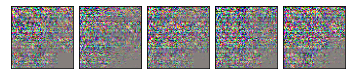

--- EPOCH 81/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.08it/s]
Discriminator loss: 1.1915301746792264
Generator loss:     0.6908567630552613


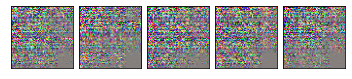

--- EPOCH 82/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.32it/s]
Discriminator loss: 1.1893070406383939
Generator loss:     0.6909034036931692


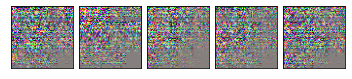

--- EPOCH 83/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.49it/s]
Discriminator loss: 1.1891136831707425
Generator loss:     0.6907573945557544


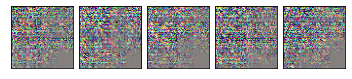

--- EPOCH 84/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.13it/s]
Discriminator loss: 1.1887791156768799
Generator loss:     0.6908187443062555


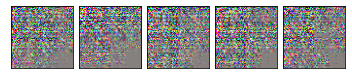

--- EPOCH 85/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.40it/s]
Discriminator loss: 1.1867600017123752
Generator loss:     0.6907677164939456


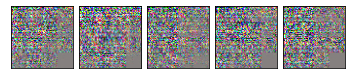

--- EPOCH 86/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.88it/s]
Discriminator loss: 1.1875814066992865
Generator loss:     0.6904129390165993


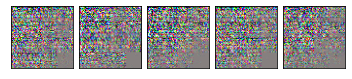

--- EPOCH 87/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.96it/s]
Discriminator loss: 1.1883738703197904
Generator loss:     0.6909806629664738


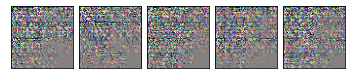

--- EPOCH 88/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.22it/s]
Discriminator loss: 1.1902701987160578
Generator loss:     0.6911361270777662


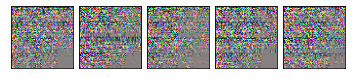

--- EPOCH 89/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.31it/s]
Discriminator loss: 1.1883875793880887
Generator loss:     0.6912589453492186


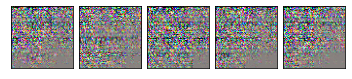

--- EPOCH 90/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.33it/s]
Discriminator loss: 1.1898143026563857
Generator loss:     0.6902353801073624


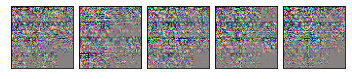

--- EPOCH 91/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.98it/s]
Discriminator loss: 1.1880385875701904
Generator loss:     0.6906434478047725


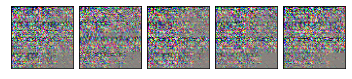

--- EPOCH 92/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.33it/s]
Discriminator loss: 1.1842776669396295
Generator loss:     0.6910705098261088


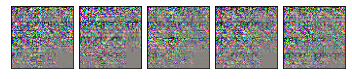

--- EPOCH 93/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.02it/s]
Discriminator loss: 1.1871880292892456
Generator loss:     0.6907843936308579


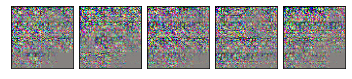

--- EPOCH 94/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.92it/s]
Discriminator loss: 1.1885721021228366
Generator loss:     0.690526313851639


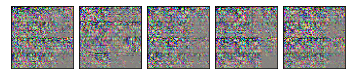

--- EPOCH 95/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.12it/s]
Discriminator loss: 1.1894011232588027
Generator loss:     0.6909130863789648


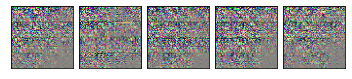

--- EPOCH 96/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.12it/s]
Discriminator loss: 1.1849725246429443
Generator loss:     0.6912677402889087


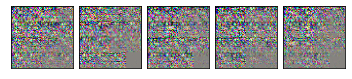

--- EPOCH 97/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.08it/s]
Discriminator loss: 1.1839762661192152
Generator loss:     0.6914082063900856


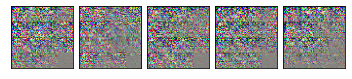

--- EPOCH 98/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.04it/s]
Discriminator loss: 1.1844037241405911
Generator loss:     0.6911605688792265


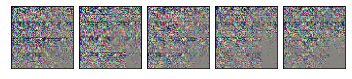

--- EPOCH 99/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.33it/s]
Discriminator loss: 1.1840729845894709
Generator loss:     0.6914630659514704


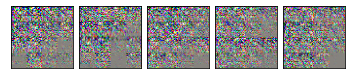

--- EPOCH 100/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.44it/s]
Discriminator loss: 1.1855221192042034
Generator loss:     0.6913750045187902


In [ ]:
import IPython.display
import tqdm
from hw3.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

In [ ]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [ ]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [ ]:
display_answer(hw3.answers.part3_q1)

### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [ ]:
display_answer(hw3.answers.part3_q2)

### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [ ]:
display_answer(hw3.answers.part3_q3)